# Extra Credit
## Austin Peng
## CSC 241
---


# 1) Random Network
---

# Single Neuron Demonstration

In [7]:
# IMPORTS
%matplotlib inline
import numpy as np
import math, sys, random
from pylab import *
from tqdm import tqdm_notebook as tqdm
import time
style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = [20, 8]

In [8]:
vrest=-65
vthresh=-50
vreset=-70
tau=20

def LIF(V, I, MFR, spike):
    V += -(1/tau) * (V - vrest) + I
    if V>vthresh:
        spike=True
        V=vreset
        MFR+=1
        
    return V, MFR, spike

In [9]:
time = range(0,1000)
n1,n2,n3=[],[],[]

def generate_neuron(membrane_potential, I, save):
    MFR = 0
    isi_list=[]
    neuron=[]
    spike=False
    
    for t in time:
        membrane_potential, MFR, spike =LIF(membrane_potential, I, MFR, spike)
        
        if(spike==True):
            isi_list.append(t)
            spike=False    
        save.append(membrane_potential)
    
    ISI = np.diff(isi_list)
    
    return MFR, ISI

print(generate_neuron(vrest, 0.8, n1))
generate_neuron(-70, 0, n2)
generate_neuron(-60, 0, n3)


(16, array([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]))


(0, array([], dtype=float64))

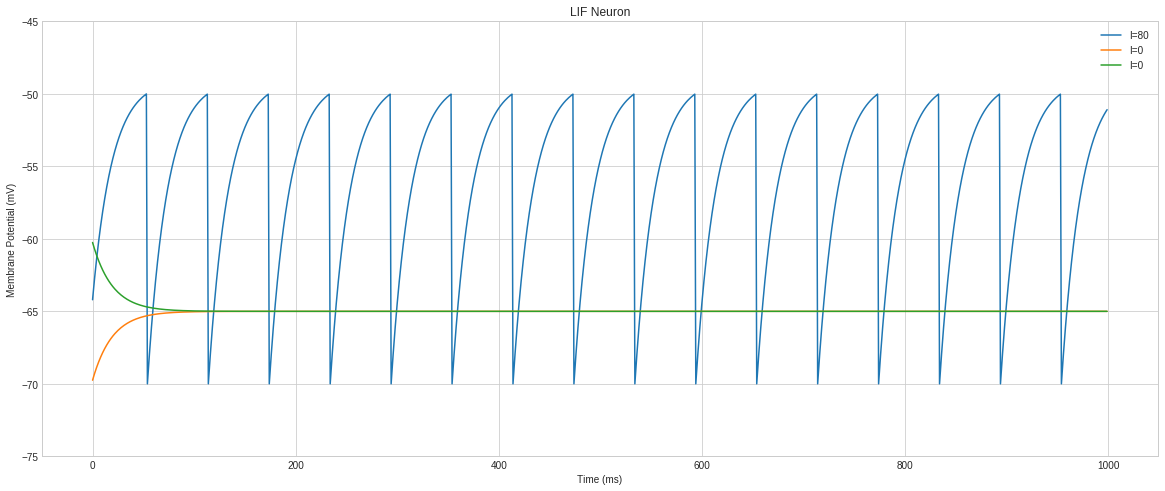

In [10]:
title("LIF Neuron")
xlabel("Time (ms)")
ylabel("Membrane Potential (mV)")
ylim([-75,-45])
plot(time, n1, label="I=80")
plot(time, n2, label="I=0")
plot(time, n3, label="I=0")
legend(loc='upper right')

show()

---
# Neuron Network

- Dales == a neuron performs the same chemical action at all of its synaptic connections to other cells, regardless of the identity of the target cell.
- CV == stdDev / mean

---

1. simulate n neurons (only made 1 neuron in assignment 1)
2. Every neuron is connected to all other ones
3. draw weight from uniform_dist(-w, w) for every indiviual weight.
4. Dales - every weight from the same neuron needs to be the same sign (pos and neg) 
5. For ^, can use -w + 2 w rand()
6. CV is still from ISI

In [12]:
# WEIGHTS
import random
def dales(n):
    dales=[]
    for x in range(n):
        dales.append(random.randint(0, 1))
    return dales
    

def generate_weights(dales, w, n):
    weights = [[i for i in range(n)] for j in range(n)]
    
    for x in range(n):
        for y in range(n):
            if(dales[x]==0):
                weights[x][y] = -abs(random.uniform(-w, w))
            else:
                weights[x][y] = abs(random.uniform(-w, w))
                
    return weights
    
weights = generate_weights(dales(n=10), w=1, n=10)
weights = np.asarray(weights)
np.fill_diagonal(weights, 0)

In [13]:
vrest=-65
vthresh=-50
vreset=-70
tau=20

def LIF(V, I, spike, weights):
    V += -(1/tau) * (V - vrest) + I + weights
    if V>vthresh:
        spike=True
        V=vreset
        
    return V, spike



1. Check which neurons spiked previously
2. For each new V(t), find relevant weights given previous neurons
3. If neuron 1 fired and neuron 2 is to be calc, use weight 1-2, not 2-1
4. Add summation to new V(t)

In [24]:
# generates membrane potential for each time bin
def generate_neuron_population(weights, I, n, runtime):
    # Columns: each neuron. Rows: V(t) and spikes
    track_membraneP=np.zeros((n, runtime))
    track_spikes=np.zeros((n, runtime))
    
    spike=False
    
    # time range 0-1000 
    for x in range(len(track_membraneP[0])):
        # neuron n
        for y in range(len(track_membraneP)):
            # new weight for each neuron
            sum_weight=0
            # new V(0) for each neuron
            V_start = random.uniform(vreset, vthresh)
            
            # basecase
            if (x==0):
                membrane_potential, spike = LIF(V_start, I, spike, 0)
                
                track_membraneP[y][x] = membrane_potential
                if(spike==True):
                    track_spikes[y][x] = 1
                    spike=False
                
            else:
                # find sum of weights
                current_neuron=y
                prev_spikes=track_spikes[:, [x-1]]
                
                for spike_num in range(len(prev_spikes)):
                    if(prev_spikes[spike_num]==1):
                        sum_weight += weights[:, [y]][spike_num]
                        
                
                # use prev time bin V(t) to set new one
                membrane_potential, spike= LIF(track_membraneP[y][x-1], I, spike, sum_weight)

                track_membraneP[y][x] = membrane_potential
                if(spike==True):
                    track_spikes[y][x] = 1
                    spike=False
                    
    return track_membraneP, track_spikes
                

    
    
track_membraneP, track_spikes = generate_neuron_population(weights, 0.8, 10, 1000)

In [25]:
def MSR_CV(track_spikes, track_membraneP):
    # find mean spike rate
    all_MSR=[]
    for x in track_spikes:
        all_MSR.append(np.sum(x))

    # find ISI CV
    all_CV=[]
    for n in range(10):
        temp=[]
        for time in range(len(track_spikes[0])):
            if(track_spikes[n][time]==1):
                temp.append(time)
        ISI = np.diff(temp)
        CV = np.std(ISI)/np.average(ISI)
        all_CV.append(CV)
    
    return np.average(all_MSR), np.average(all_CV)


exampleMSR, exampleCV = MSR_CV(track_spikes, track_membraneP)
print("Mean MSR: ", exampleMSR)
print("Mean CV: ", exampleCV)


Mean MSR:  18.1
Mean CV:  0.04665863405977112


# As a function of W and I 

- Vary W and I and create a network for each variation
- Plot two graphs, one of Firing Rate, one of CV. Both varied by I and W. 
___

In [34]:
# neuron pop, weight w, input, runtime
def vary_W_I(n, w, I, runtime):
    # make weight matrix
    weights = generate_weights(dales(n), w, n)
    weights = np.asarray(weights)
    np.fill_diagonal(weights, 0)

    # make neuron population
    track_membraneP, track_spikes = generate_neuron_population(weights, I, n, runtime)

    # get MSR CV
    exampleMSR, exampleCV = MSR_CV(track_spikes, track_membraneP)
    time = runtime/1000
    
    return exampleMSR/time, exampleCV/time


In [38]:
MSR, CV = vary_W_I(10, 1, 0.8, 1000)
print(MSR, CV)

17.1 0.014998459372444558


# With 10 neurons, 1000ms:
___

In [59]:
weight_range=10
I_range=10

plot1=np.zeros((weight_range, I_range))
plot2=np.zeros((weight_range, I_range))


for w in tqdm(range(weight_range)):
    for i in range(I_range):
        MSR, CV = vary_W_I(10, w, i, 1000)
        plot1[w,i] = MSR
        plot2[w,i] = CV

/home/harold/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/harold/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/harold/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/harold/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/harold/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


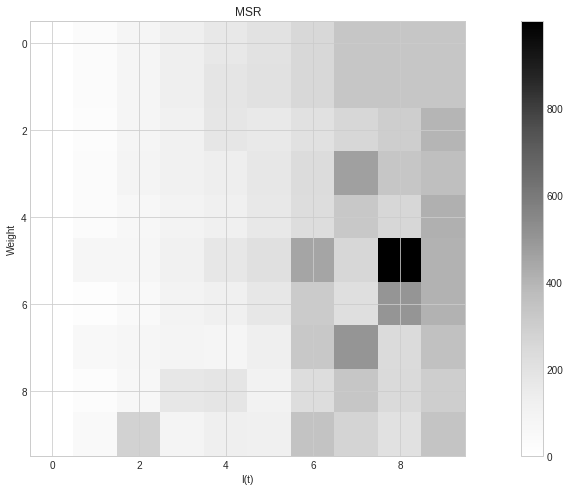

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(plot1);
plt.title("MSR")
plt.xlabel("I(t)")
plt.ylabel("Weight")
plt.colorbar()
plt.show()

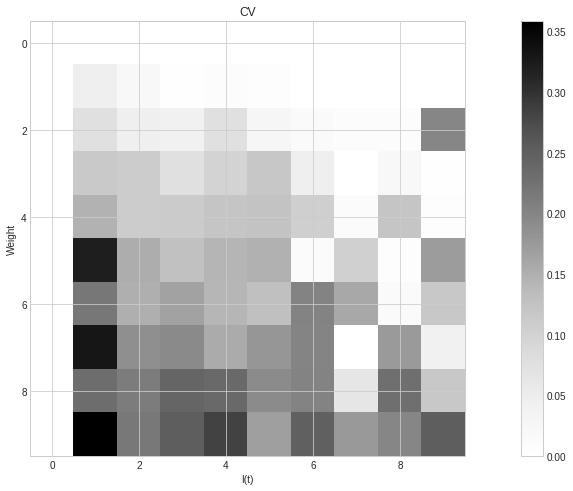

In [61]:
plt.imshow(plot2);
plt.title("CV")
plt.xlabel("I(t)")
plt.ylabel("Weight")
plt.colorbar()
plt.show()

# With 20 neurons, 5000ms:
___

In [43]:
weight_range=10
I_range=10

plot1=np.zeros((weight_range, I_range))
plot2=np.zeros((weight_range, I_range))


for w in tqdm(range(weight_range)):
    for i in range(I_range):
        MSR, CV = vary_W_I(20, w, i, 5000)
        plot1[w,i] = MSR
        plot2[w,i] = CV

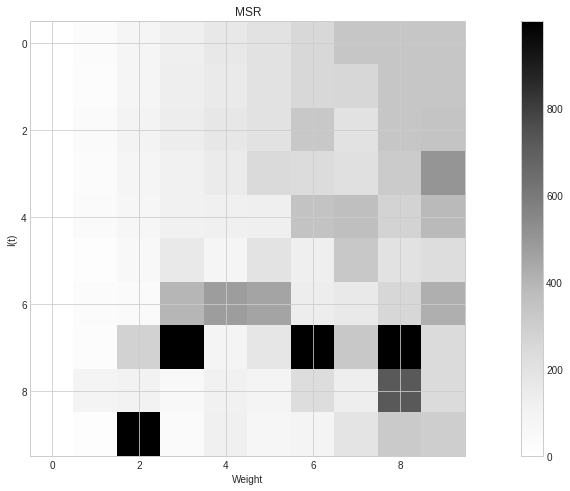

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(plot1);
plt.title("MSR")
plt.xlabel("I(t)")
plt.ylabel("Weight")
plt.colorbar()
plt.show()

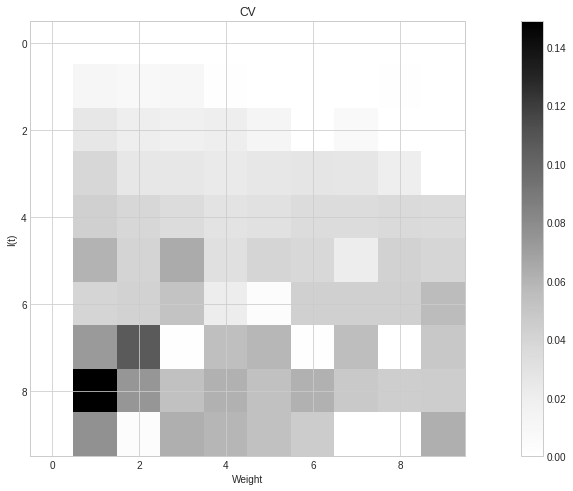

In [45]:
plt.imshow(plot2);
plt.title("CV")
plt.xlabel("I(t)")
plt.ylabel("Weight")
plt.colorbar()
plt.show()

# 2) Sensory Network
---

- Two pools of neurons now, with weights between the pools
- weights within each pool is the same


In [58]:
foo = np.zeros((5,5))
for i in range(5):
    for x in range(5):
            foo[i][x] = x
            
print(foo)

[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
